# PDE-Net求解对流扩散方程

## 概述

PDE-Net是Zichao Long等人提出的一种前馈深度网络用于从数据中学习偏微分方程，同时实现了准确预测复杂系统的动力学特性和揭示潜在的PDE模型。PDE-Net的基本思想是通过学习卷积核(滤波器)来逼近微分算子，并应用神经网络或其他机器学习方法来拟合未知的非线性响应。数值实验表明，即使在噪声环境中，该模型也可以识别被观测的动力学方程，并预测相对较长时间的动态行为。更多信息可参考[PDE-Net: Learning PDEs from Data](https://arxiv.org/abs/1710.09668)。

本案例要求**MindSpore版本 >= 2.0.0**以调用如下接口: *mindspore.jit, mindspore.jit_class, mindspore.data_sink*。

## 问题描述

本案例求解可变参数的对流-扩散偏微分方程的反问题，并实现长期预测。

## 控制方程

在本研究中，对流扩散方程的形式为：

$$
u_t = a(x,y) u_x + b(x,y) u_y + c u_{xx} + d u_{yy}, \quad (x,y) \in[0,2 \pi] \times[0,2 \pi]
$$

$$
u|_{t=0} = u_0(x,y)
$$

各项导数的系数分别为：

$$
a(x,y)=0.5(cos(y)+x(2\pi-x)sin(x))+0.6 \quad
b(x,y)=2(cos(y)+sin(x))+0.8
$$

$$
c=0.2 \quad
d=0.3
$$


## PDE-Net的模型结构

PDE-Net由多个$\delta T$ Block串联构成，以实现长序列信息的预测，在每一个$\delta T$ Block中，包含可训练参数的moment矩阵，该矩阵可根据映射关系转化为对应导数的卷积核，从而获取物理场的导数。将导数及其对应物理量经线性组合后，采用前向欧拉法，即可推导下一个时间步的信息。

![](images/pdenet-1.jpg)

![](images/pdenet-2.jpg)

## 技术路径

MindFlow求解该问题的具体流程如下：

1. 构建模型。
2. 单步训练。
3. 多步训练。
4. 模型推理及可视化。

In [1]:
import os
import time
import numpy as np

import mindspore
from mindspore.common import set_seed
from mindspore import nn, Tensor, context, ops, jit
from mindspore.train.serialization import load_param_into_net

In [2]:
from mindflow.cell import PDENet
from mindflow.utils import load_yaml_config
from mindflow.loss import get_loss_metric, RelativeRMSELoss
from mindflow.pde import UnsteadyFlowWithLoss

from src import init_model, create_dataset, calculate_lp_loss_error
from src import make_dir, scheduler, get_param_dic
from src import plot_coe, plot_extrapolation_error, get_label_coe, plot_test_error

In [ ]:
set_seed(0)
np.random.seed(0)
context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=0)

In [4]:
# load configuration yaml
config = load_yaml_config('pde_net.yaml')
config["kernel_size"]=7
config["summary_dir"] = "./summary_dir/summary_kernel_7"
config["mindrecord_data_dir"] = "./data7"

## 构建模型

MindFlow提供了`PDENet`接口可以直接建立PDENet模型，需指定网格的宽度、高度、数据深度、边界条件、拟合的最高阶数等信息。

In [7]:
def init_model(config):
    return PDENet(height=config["mesh_size"],
                  width=config["mesh_size"],
                  channels=config["channels"],
                  kernel_size=config["kernel_size"],
                  max_order=config["max_order"],
                  dx=2 * np.pi / config["mesh_size"],
                  dy=2 * np.pi / config["mesh_size"],
                  dt=config["dt"],
                  periodic=config["perodic_padding"],
                  enable_moment=config["enable_moment"],
                  if_fronzen=config["if_frozen"],
                  )

## 单步训练

由于每个$\delta T$ Block的参数是共享的，因此模型根据$\delta T$ Block的串联个数依次增加，逐一进行训练。其中，在step为1时，模型处于warm-up阶段，PDE-Net的moment为“frozen”状态，此时moment中的参数不参与训练。每新增一个$\delta T$ Block，程序先进行数据生成和数据集的读取，初始化模型后，需载入前一个step训练的checkpoint，并定义优化器、模式、loss函数，并进行模型训练，在训练中模型会实时反映模型性能。

In [8]:
def train_single_step(step, config, lr, train_dataset, eval_dataset):
    """train PDE-Net with advancing steps"""

    print("Current step for train loop: {}".format(step, ))
    model = init_model(config)

    epoch = config["epochs"]
    warm_up_epoch_scale = 10
    if step == 1:
        model.if_fronzen = True
        epoch = warm_up_epoch_scale * epoch
    elif step == 2:
        param_dict = get_param_dic(config["summary_dir"], step - 1, epoch * 10)
        load_param_into_net(model, param_dict)
        print("Load pre-trained model successfully")
    else:
        param_dict = get_param_dic(config["summary_dir"], step - 1, epoch)
        load_param_into_net(model, param_dict)
        print("Load pre-trained model successfully")

    optimizer = nn.Adam(model.trainable_params(), learning_rate=Tensor(lr))
    problem = UnsteadyFlowWithLoss(model, t_out=step, loss_fn=RelativeRMSELoss(), data_format="NTCHW")

    def forward_fn(u0, uT):
        loss = problem.get_loss(u0, uT)
        return loss

    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    @jit
    def train_step(u0, uT):
        loss, grads = grad_fn(u0, uT)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    steps = train_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, train_dataset, sink_size=1)

    for cur_epoch in range(epoch):
        local_time_beg = time.time()
        model.set_train()

        for _ in range(steps):
            cur_loss = sink_process()
            print("epoch: %s, loss is %s" % (cur_epoch + 1, cur_loss), flush=True)
        local_time_end = time.time()
        epoch_seconds = (local_time_end - local_time_beg) * 1000
        step_seconds = epoch_seconds / steps
        print("Train epoch time: {:5.3f} ms, per step time: {:5.3f} ms".format
              (epoch_seconds, step_seconds), flush=True)

        if (cur_epoch + 1) % config["save_epoch_interval"] == 0:
            ckpt_file_name = "ckpt/step_{}".format(step)
            ckpt_dir = os.path.join(config["summary_dir"], ckpt_file_name)
            if not os.path.exists(ckpt_dir):
                make_dir(ckpt_dir)
            ckpt_name = "pdenet-{}.ckpt".format(cur_epoch + 1, )
            mindspore.save_checkpoint(model, os.path.join(ckpt_dir, ckpt_name))

        if (cur_epoch + 1) % config['eval_interval'] == 0:
            calculate_lp_loss_error(problem, eval_dataset, config["batch_size"])

## 多步训练

PDE-Net是逐步进行训练。
使用**MindSpore>= 2.0.0**的版本，可以使用函数式编程范式训练神经网络。

In [9]:
def train(config):
    lr = config["lr"]
    for i in range(1, config["multi_step"] + 1):
        db_name = "train_step{}.mindrecord".format(i)
        dataset = create_dataset(config, i, db_name, "train", data_size=2 * config["batch_size"])
        train_dataset, eval_dataset = dataset.create_train_dataset()
        lr = scheduler(int(config["multi_step"] / config["learning_rate_reduce_times"]), step=i, lr=lr)
        train_single_step(step=i, config=config, lr=lr, train_dataset=train_dataset, eval_dataset=eval_dataset)


In [ ]:
if not os.path.exists(config["mindrecord_data_dir"]):
    make_dir(config["mindrecord_data_dir"])
train(config)

[WARNING] ME(191916:140423743628992,MainProcess):2025-06-15-18:11:34.175.474 [mindspore/dataset/engine/datasets.py:1145] Dataset is shuffled before split.


Mindrecorder saved
Current step for train loop: 1
epoch: 1, loss is 399.63153
Train epoch time: 8711.407 ms, per step time: 8711.407 ms
epoch: 2, loss is 368.58313
Train epoch time: 11.759 ms, per step time: 11.759 ms
epoch: 3, loss is 376.73456
Train epoch time: 9.326 ms, per step time: 9.326 ms
epoch: 4, loss is 385.64487
Train epoch time: 9.783 ms, per step time: 9.783 ms
epoch: 5, loss is 381.92505
Train epoch time: 9.241 ms, per step time: 9.241 ms
epoch: 6, loss is 374.3224
Train epoch time: 7.941 ms, per step time: 7.941 ms
epoch: 7, loss is 381.59882
Train epoch time: 9.654 ms, per step time: 9.654 ms
epoch: 8, loss is 354.87573
Train epoch time: 8.944 ms, per step time: 8.944 ms
epoch: 9, loss is 382.589
Train epoch time: 11.215 ms, per step time: 11.215 ms
epoch: 10, loss is 354.3843
Train epoch time: 9.098 ms, per step time: 9.098 ms
================================Start Evaluation================================
LpLoss_error: 21.076649
=================================End E

## 模型推理及可视化

完成训练后，下图展示了预测结果和真是标签的对比情况。

In [5]:
from src.utils import plot_test_error
step = 20
test_data_size = 20

model = init_model(config)
param_dict = get_param_dic(config["summary_dir"], config["multi_step"], config["epochs"])
load_param_into_net(model, param_dict)

([], [])

### Plot Coefficient

6


/home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/src/utils.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, pad=0.2, w_pad=0.2, h_pad=0.2)


6


/home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/src/utils.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, pad=0.2, w_pad=0.2, h_pad=0.2)


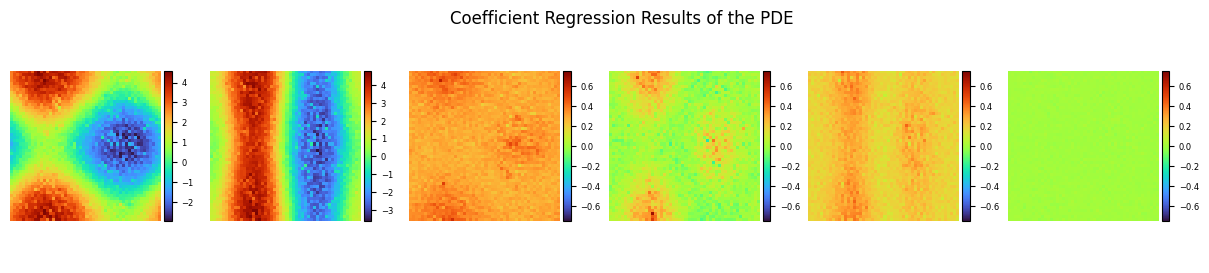

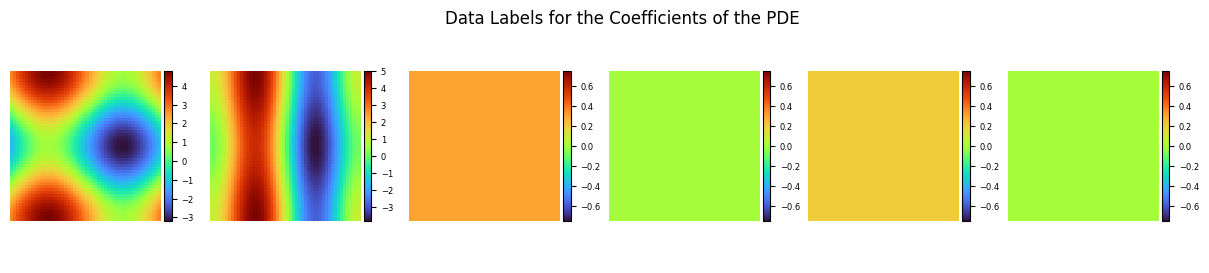

In [19]:
from src.utils import get_label_coe,plot_coe,plot_coe_label
coe_label = get_label_coe(max_order=config["max_order"], resolution=config["mesh_size"])
coes_out_dir = os.path.join(config["figure_out_dir"], "coes")
plot_coe(model.coe, coes_out_dir, prefix="coe_trained", step=step, title="Coefficient Regression Results of the PDE")
plot_coe_label(coe_label, coes_out_dir, prefix="coe_label", title="Data Labels for the Coefficients of the PDE")

### Plot Test Error

[WARNING] MD(570144,7f05c6d436c0,python):2025-06-15-20:56:34.456.933 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:95] OpenDataFiles] Succeed to remove the old mindrecord files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data7/eval.mindrecord
[WARNING] MD(570144,7f05c6d436c0,python):2025-06-15-20:56:34.458.211 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:104] OpenDataFiles] Succeed to remove the old mindrecord metadata files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data7/eval.mindrecord.db
[WARNING] MD(570144,7f048dfff700,python):2025-06-15-20:56:34.495.014 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 96.5633%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f

Mindrecorder saved
sample 25, MSE Loss 0.0
sample 25, MSE Loss 0.041023985


[WARNING] MD(570144,7f05c6d436c0,python):2025-06-15-20:56:37.613.033 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:95] OpenDataFiles] Succeed to remove the old mindrecord files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data7/eval.mindrecord
[WARNING] MD(570144,7f05c6d436c0,python):2025-06-15-20:56:37.613.094 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:104] OpenDataFiles] Succeed to remove the old mindrecord metadata files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data7/eval.mindrecord.db
[WARNING] MD(570144,7f048dfff700,python):2025-06-15-20:56:37.654.729 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 96.5526%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f

Mindrecorder saved
sample 50, MSE Loss 0.044190276


[WARNING] MD(570144,7f05c6d436c0,python):2025-06-15-20:56:40.604.853 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:95] OpenDataFiles] Succeed to remove the old mindrecord files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data7/eval.mindrecord
[WARNING] MD(570144,7f05c6d436c0,python):2025-06-15-20:56:40.604.920 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:104] OpenDataFiles] Succeed to remove the old mindrecord metadata files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data7/eval.mindrecord.db
[WARNING] MD(570144,7f048dfff700,python):2025-06-15-20:56:40.665.089 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 96.5849%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f

Mindrecorder saved
sample 75, MSE Loss 0.021335345


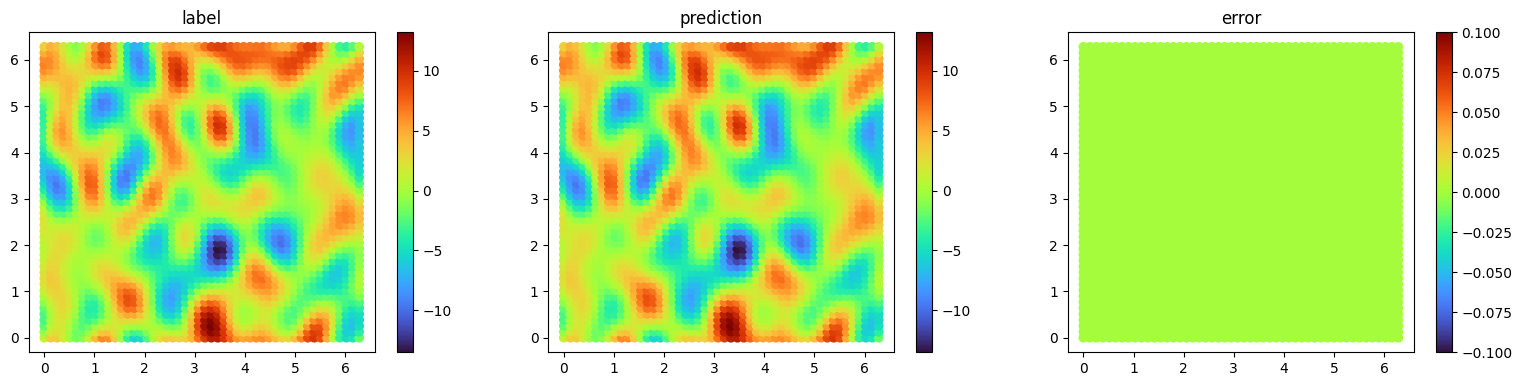

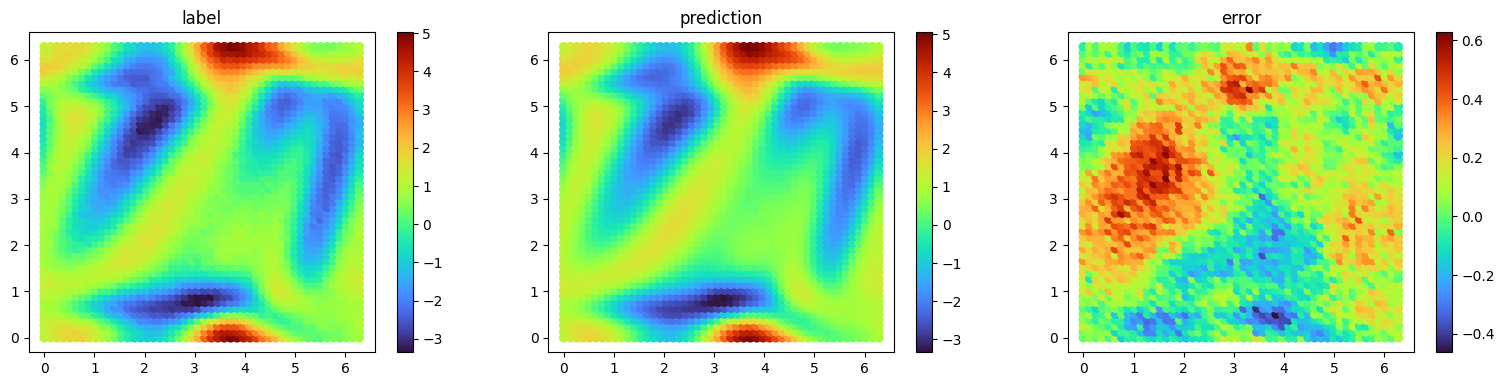

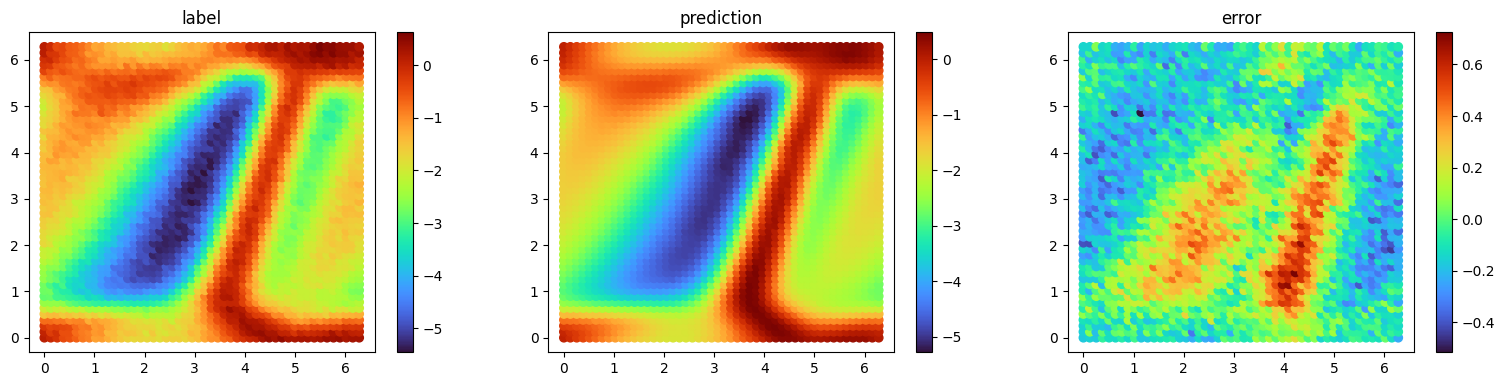

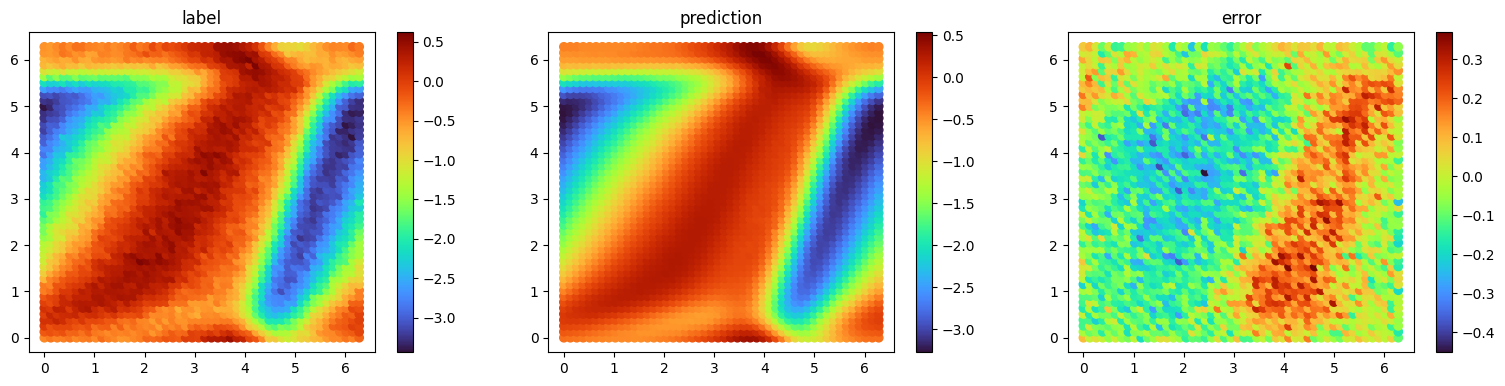

In [8]:

from src.utils import plot_test_error_0
zero_plot_flag = False
for current_step in [25,50,75]:
    problem = UnsteadyFlowWithLoss(model, t_out=current_step, loss_fn=RelativeRMSELoss(), data_format="NTCHW")
    dataset = create_dataset(config, current_step, "eval.mindrecord", "test", data_size=1)
    test_dataset = dataset.create_test_dataset(current_step)
    iterator_test_dataset = test_dataset.create_dict_iterator()
    final_item = [_ for _ in iterator_test_dataset][-1]
    if not zero_plot_flag:
        plot_test_error_0(problem, get_loss_metric("mse"), final_item, current_step, config["mesh_size"], config["figure_out_dir"])
        zero_plot_flag = True
    plot_test_error(problem, get_loss_metric("mse"), final_item, current_step, config["mesh_size"], config["figure_out_dir"])

### Plot Extrapolation Error

[WARNING] MD(570144,7f05c6d436c0,python):2025-06-15-20:23:33.722.770 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:95] OpenDataFiles] Succeed to remove the old mindrecord files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data7/extrapolation.mindrecord
[WARNING] MD(570144,7f05c6d436c0,python):2025-06-15-20:23:33.722.835 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:104] OpenDataFiles] Succeed to remove the old mindrecord metadata files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data7/extrapolation.mindrecord.db


Mindrecorder saved


[WARNING] MD(570144,7f0398ffd700,python):2025-06-15-20:24:58.952.234 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.0294%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f0398ffd700,python):2025-06-15-20:24:58.960.830 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.0336%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f0398ffd700,python):2025-06-15-20:24:58.981.276 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.0365%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 1, p25 = 0.04825, p75 = 0.07176


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:04.208.728 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2367%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:04.229.441 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2387%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:04.239.914 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2396%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 2, p25 = 0.04860, p75 = 0.08554


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:09.469.952 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2512%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:09.476.061 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2521%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:09.484.395 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2521%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 3, p25 = 0.05830, p75 = 0.10564


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:14.951.607 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3503%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:14.979.922 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.321%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:14.989.009 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3184%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / othe

step = 4, p25 = 0.06476, p75 = 0.12168


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:20.532.163 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2989%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:20.544.894 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3017%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:20.555.063 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3033%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 5, p25 = 0.07165, p75 = 0.13046


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:26.548.457 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3028%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:26.565.782 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3008%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:26.577.037 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3014%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 6, p25 = 0.07649, p75 = 0.13755


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:32.680.886 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3327%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:32.688.051 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3327%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:32.696.521 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3327%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 7, p25 = 0.07852, p75 = 0.14028


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:38.768.903 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3339%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:38.777.406 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3339%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:38.787.131 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3339%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 8, p25 = 0.08015, p75 = 0.14541


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:45.126.358 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3396%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:45.132.595 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3396%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:45.146.623 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2982%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 9, p25 = 0.08151, p75 = 0.14534


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:51.703.419 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3062%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:51.713.837 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3067%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:51.721.923 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3068%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 10, p25 = 0.08150, p75 = 0.14681


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:58.208.826 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2862%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:58.220.868 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2861%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:25:58.230.451 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2861%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 11, p25 = 0.08323, p75 = 0.14874


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:05.088.775 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2957%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:05.105.655 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2966%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:05.113.107 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2966%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 12, p25 = 0.08377, p75 = 0.14896


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:11.959.427 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.306%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:11.975.821 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3085%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:11.994.949 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3095%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / othe

step = 13, p25 = 0.08649, p75 = 0.14923


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:19.077.457 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3604%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:19.088.414 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3541%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:19.101.931 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3531%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 14, p25 = 0.08647, p75 = 0.15047


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:26.226.155 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2861%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:26.239.146 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2861%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:26.267.666 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.2861%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 15, p25 = 0.08779, p75 = 0.15124


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:33.690.844 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3464%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:33.721.538 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3464%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:33.730.619 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3464%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 16, p25 = 0.08813, p75 = 0.14912


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:41.413.858 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3299%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:41.423.917 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3309%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:41.431.205 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3291%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 17, p25 = 0.08833, p75 = 0.14528


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:49.130.431 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3525%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:49.142.394 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3535%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:49.157.158 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3554%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 18, p25 = 0.08930, p75 = 0.14382


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:56.998.417 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3473%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:57.016.385 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3531%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:26:57.029.243 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3521%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 19, p25 = 0.09034, p75 = 0.14346


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:04.952.403 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3798%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:04.955.846 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3807%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:04.969.695 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.379%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / othe

step = 20, p25 = 0.09170, p75 = 0.14485


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:13.055.351 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.358%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:13.064.968 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.358%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:13.074.650 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.358%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other 

step = 21, p25 = 0.08996, p75 = 0.14689


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:21.311.869 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3828%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:21.322.591 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3828%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:21.337.495 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3828%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 22, p25 = 0.08939, p75 = 0.15112


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:29.809.632 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3745%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:29.816.370 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3743%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:29.826.649 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3781%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 23, p25 = 0.08722, p75 = 0.15303


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:38.695.271 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3997%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:38.722.471 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3997%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:38.736.557 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3997%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 24, p25 = 0.08783, p75 = 0.15451


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:47.415.635 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3628%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:47.424.272 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3529%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:47.439.319 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3624%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 25, p25 = 0.08679, p75 = 0.15845


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:56.301.836 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3839%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:56.326.072 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3839%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:27:56.329.145 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3839%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 26, p25 = 0.08845, p75 = 0.16077


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:05.139.516 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3426%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:05.154.948 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3427%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:05.171.069 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3427%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 27, p25 = 0.08847, p75 = 0.16191


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:14.233.780 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.364%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:14.251.334 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.364%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:14.264.800 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.364%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other 

step = 28, p25 = 0.08971, p75 = 0.16331


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:23.453.390 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3244%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:23.464.374 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3244%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:23.479.317 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3244%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 29, p25 = 0.09021, p75 = 0.16471


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:33.101.971 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3885%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:33.108.069 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3885%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:33.116.982 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3885%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 30, p25 = 0.09036, p75 = 0.16447


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:42.822.809 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3326%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:42.833.344 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3328%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:42.841.684 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3328%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 31, p25 = 0.09088, p75 = 0.16627


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:52.530.983 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3953%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:52.534.834 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3953%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:28:52.548.610 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3953%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 32, p25 = 0.09066, p75 = 0.16688


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:02.321.202 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3555%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:02.337.068 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3555%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:02.343.031 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3555%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 33, p25 = 0.09037, p75 = 0.16580


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:12.310.188 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.4006%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:12.320.223 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.4007%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:12.329.687 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.4007%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 34, p25 = 0.09053, p75 = 0.16354


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:22.554.228 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.366%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:22.557.490 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.366%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:22.569.342 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3664%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other

step = 35, p25 = 0.09071, p75 = 0.16347


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:33.104.727 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3631%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:33.125.205 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3631%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:33.138.291 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3631%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 36, p25 = 0.09101, p75 = 0.16492


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:43.534.759 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.339%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:43.548.108 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.339%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:43.558.884 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.339%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other 

step = 37, p25 = 0.09100, p75 = 0.16668


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:53.990.867 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3736%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:53.998.836 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3743%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:29:54.006.337 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3743%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 38, p25 = 0.09041, p75 = 0.16758


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:04.842.806 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.374%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:04.856.817 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3749%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:04.870.995 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3749%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / othe

step = 39, p25 = 0.09078, p75 = 0.17010


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:15.743.963 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3824%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:15.752.119 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3834%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:15.758.191 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3834%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 40, p25 = 0.09087, p75 = 0.17341


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:26.679.369 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3603%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:26.689.912 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3603%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:26.696.177 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3603%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 41, p25 = 0.09138, p75 = 0.17629


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:38.085.788 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3627%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:38.097.952 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3627%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:38.103.996 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3627%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 42, p25 = 0.09149, p75 = 0.17849


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:49.357.877 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.358%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:49.364.247 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.358%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:30:49.373.234 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3591%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other

step = 43, p25 = 0.09164, p75 = 0.17994


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:00.940.929 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3576%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:00.950.433 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3576%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:00.958.597 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3576%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 44, p25 = 0.09196, p75 = 0.18063


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:12.645.024 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3278%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:12.661.656 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3278%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:12.687.019 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3282%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 45, p25 = 0.09257, p75 = 0.18246


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:24.464.747 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.4361%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:24.480.981 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.4361%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:24.483.581 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.4352%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 46, p25 = 0.09179, p75 = 0.18356


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:36.565.978 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.33%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:36.577.682 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3299%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:36.590.026 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3299%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other

step = 47, p25 = 0.09100, p75 = 0.18690


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:48.801.301 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.342%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:48.806.003 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.342%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:31:48.809.516 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.342%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other 

step = 48, p25 = 0.09104, p75 = 0.18945


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:00.938.244 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3643%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:00.960.837 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3658%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:00.963.006 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3658%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 49, p25 = 0.08939, p75 = 0.19165


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:13.401.061 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.361%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:13.415.218 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.361%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:13.424.906 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.361%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other 

step = 50, p25 = 0.08836, p75 = 0.19384


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:26.125.826 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3552%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:26.134.586 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3552%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:26.149.508 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3552%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 51, p25 = 0.08759, p75 = 0.19615


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:39.057.040 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3276%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:39.069.511 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3289%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:39.084.180 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3336%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 52, p25 = 0.08689, p75 = 0.19885


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:52.005.174 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.393%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:52.015.099 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3533%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:32:52.024.525 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3596%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / othe

step = 53, p25 = 0.08556, p75 = 0.20043


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:05.271.329 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3391%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:05.289.606 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3394%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:05.297.733 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3398%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 54, p25 = 0.08461, p75 = 0.20399


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:18.480.734 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3829%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:18.505.268 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3768%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:18.513.466 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3768%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 55, p25 = 0.08391, p75 = 0.20539


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:31.885.054 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.397%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:31.891.329 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3528%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:31.905.030 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3557%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / othe

step = 56, p25 = 0.08369, p75 = 0.20750


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:45.710.819 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.368%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:45.717.248 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.368%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:45.723.317 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.368%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other 

step = 57, p25 = 0.08212, p75 = 0.20907


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:59.366.832 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3488%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:59.377.722 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3498%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:33:59.382.986 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3498%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 58, p25 = 0.08206, p75 = 0.21269


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:34:13.214.352 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3707%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:34:13.224.021 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3707%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:34:13.236.318 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3707%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 59, p25 = 0.08173, p75 = 0.21459


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:34:27.424.815 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3583%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:34:27.436.578 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3794%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:34:27.442.683 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3824%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 60, p25 = 0.07966, p75 = 0.21596


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:34:41.719.916 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3743%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:34:41.732.027 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3743%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:34:41.748.614 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3743%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 61, p25 = 0.07885, p75 = 0.21909


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:34:56.117.482 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3465%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:34:56.126.560 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3464%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:34:56.128.591 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3464%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 62, p25 = 0.07876, p75 = 0.22273


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:35:10.501.801 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3655%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:35:10.508.334 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3655%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:35:10.516.749 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3659%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 63, p25 = 0.07825, p75 = 0.22559


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:35:25.149.804 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3911%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:35:25.162.227 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3911%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:35:25.174.226 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3911%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 64, p25 = 0.07787, p75 = 0.22669


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:35:40.017.302 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3813%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:35:40.029.413 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3813%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:35:40.048.758 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3813%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 65, p25 = 0.07748, p75 = 0.23032


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:35:55.029.343 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3985%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:35:55.044.603 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3985%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:35:55.057.869 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3985%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 66, p25 = 0.07744, p75 = 0.23457


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:36:10.055.652 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3697%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:36:10.059.983 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3697%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:36:10.073.760 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3703%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 67, p25 = 0.07722, p75 = 0.23773


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:36:25.315.927 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.4106%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:36:25.330.216 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.4106%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:36:25.344.093 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.4106%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 68, p25 = 0.07842, p75 = 0.24085


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:36:40.797.308 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3713%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:36:40.807.228 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3713%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:36:40.820.019 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3713%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 69, p25 = 0.07850, p75 = 0.24265


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:36:56.443.475 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.4203%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:36:56.448.266 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.4203%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:36:56.472.137 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.4206%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 70, p25 = 0.07902, p75 = 0.24457


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:37:12.136.525 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3746%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:37:12.153.847 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3754%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:37:12.164.796 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.3754%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 71, p25 = 0.07995, p75 = 0.25041


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:37:28.430.310 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2456%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:37:28.436.337 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2456%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:37:28.457.492 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2456%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 72, p25 = 0.07957, p75 = 0.25467


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:37:44.515.021 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.3081%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:37:44.521.573 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.3088%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:37:44.535.617 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.3087%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 73, p25 = 0.07971, p75 = 0.25609


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:38:00.609.390 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2947%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:38:00.628.003 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2947%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:38:00.630.790 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2947%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 74, p25 = 0.07969, p75 = 0.25755


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:38:17.057.963 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2334%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:38:17.062.337 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2334%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:38:17.072.296 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2334%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 75, p25 = 0.07940, p75 = 0.26115


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:38:33.689.556 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2856%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:38:33.710.411 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2856%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:38:33.724.920 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2675%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 76, p25 = 0.07987, p75 = 0.26207


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:38:50.563.796 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2398%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:38:50.569.852 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2399%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:38:50.583.402 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2399%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 77, p25 = 0.07996, p75 = 0.26401


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:39:08.051.692 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 93.3707%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:39:08.065.152 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 93.371%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:39:08.082.083 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 93.371%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other

step = 78, p25 = 0.08006, p75 = 0.26664


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:39:24.912.471 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 93.2883%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:39:24.922.168 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 93.2883%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:39:24.930.225 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 93.2883%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 79, p25 = 0.08045, p75 = 0.26851


[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:39:42.134.420 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 93.3063%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:39:42.144.783 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 93.3063%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(570144,7f04057fe700,python):2025-06-15-20:39:42.153.279 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 93.3067%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / oth

step = 80, p25 = 0.08107, p75 = 0.27035


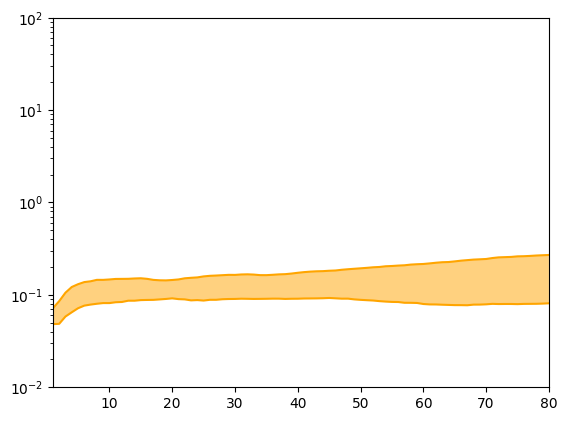

In [7]:
max_step = 80
sample_size = 40

dataset = create_dataset(config, max_step, "extrapolation.mindrecord", "test", data_size=sample_size)
plot_extrapolation_error(config, dataset, max_step=max_step)